<a href="https://colab.research.google.com/github/Yvonne-Li/Kaggle-ELL-Assessment/blob/main/ML_BERT_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
### Load necessary packages
import pandas as pd
import numpy as np
import os
import string
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')
import re

import seaborn as sns

from collections import Counter
from collections import defaultdict
from IPython.core.display import display, HTML


from google.colab import drive
drive.mount('/content/gdrive')


absolute_path = '/content/gdrive/MyDrive/EEL_dataset/'

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#### read in the dataset
sample_sub = pd.read_csv(absolute_path + 'sample_submission.csv')
test_ds = pd.read_csv(absolute_path + 'test.csv')
train_ds = pd.read_csv(absolute_path + 'train.csv.zip')

In [ ]:
## First look at the dataset.
## text_id, text content and six grading metrics.
train_ds

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5
...,...,...,...,...,...,...,...,...
3906,FFD29828A873,I believe using cellphones in class for educat...,2.5,3.0,3.0,3.5,2.5,2.5
3907,FFD9A83B0849,"Working alone, students do not have to argue w...",4.0,4.0,4.0,4.0,3.5,3.0
3908,FFDC4011AC9C,"""A problem is a chance for you to do your best...",2.5,3.0,3.0,3.0,3.5,3.0
3909,FFE16D704B16,Many people disagree with Albert Schweitzer's ...,4.0,4.5,4.5,4.0,4.5,4.5


In [ ]:
## get the grading metrics and saved as EEL_metrics.
EEL_metrics = train_ds.columns[-6:]
len(EEL_metrics)

6

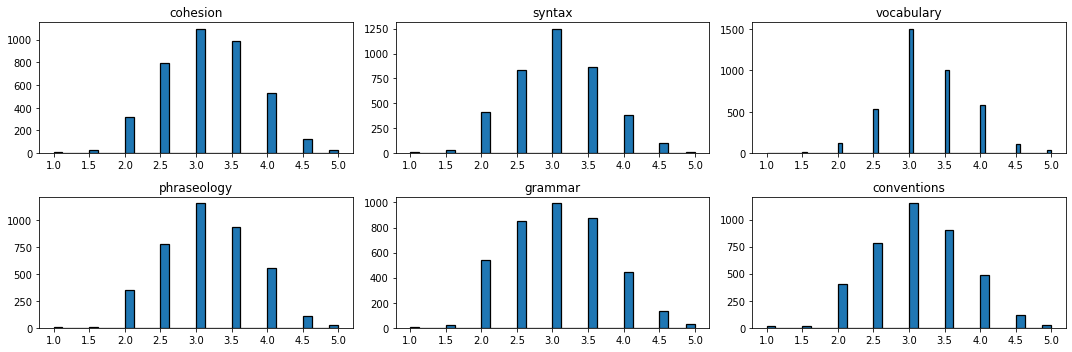

In [ ]:
# First check the dataset, num of each grade catergories
# the distribution is quite imbalance, as the grades has only 9 different ranks
## from 1 to 5 with 0.5 step
fig, axes = plt.subplots(2, len(EEL_metrics)//2, figsize=(15,5))

for i, EEL_metric in enumerate(EEL_metrics):
    ax = axes.flat[i]
    sns.histplot(x=EEL_metric, data=train_ds, linewidth=1.25, alpha=1, ax=ax, zorder=2)
    ax.set_title(EEL_metric)
    ax.set(xlabel=None, ylabel=None)

#fig.suptitle('Output Variables')
plt.tight_layout()
plt.show()

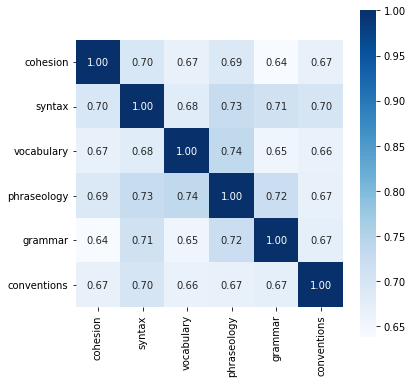

In [ ]:
# Frist glace at the correlations between these six metrics
# somewhat correlated.
corr = train_ds[EEL_metrics].corr()
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(corr,
            xticklabels=corr.columns, yticklabels=corr.columns,
            square=True, annot=True, cmap="Blues", fmt=".2f")
plt.show()

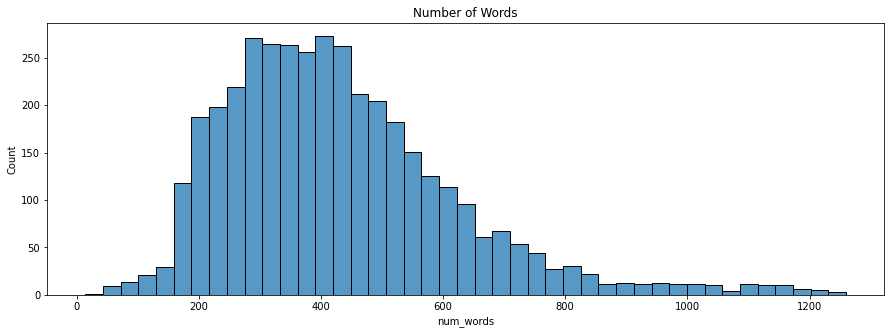

In [ ]:
### check the number of words in each essay.
fig = plt.figure(figsize=(15, 5))
train_ds['num_words'] = train_ds['full_text'].apply(lambda x: len(x.split()))
sns.histplot(data=train_ds, x="num_words")
plt.title("Number of Words")
plt.show()

In [ ]:
## Since this is imbalanced dataset, trying to split it with the same ratio as for
## validation dataset, meanwhile, the practical distribution of the grades is quite
## similar to what we see here, skewed gaussion distribution.

train_ds['total_score'] = train_ds[EEL_metrics].sum(axis=1)
train_ds_sorted = train_ds.sort_values('total_score')

In [ ]:
## sorted by the total_score and then split the data by total_score
train_ds_sorted['new_index'] = range(train_ds_sorted.shape[0])
train_ds_sorted.set_index('new_index',inplace=True)

In [ ]:
train_ds_sorted.loc[0]

text_id                                             767533E12569
full_text      he is a good because they are the prescient an...
cohesion                                                     1.0
syntax                                                       1.0
vocabulary                                                   1.0
phraseology                                                  1.0
grammar                                                      1.0
conventions                                                  1.0
num_words                                                    253
total_score                                                  6.0
Name: 0, dtype: object

In [ ]:
### split the dataset, every 4 texts, 1 was loaded for validation and 3 for training
X_train=[]
y_train=[]
X_val=[]
y_val=[]
for i in range(train_ds_sorted.shape[0]):
    if i % 4 == 0:
        X_val.append(train_ds_sorted.loc[i]['full_text'])
        y_val.append(train_ds_sorted.loc[i][EEL_metrics].values)
    else:
        X_train.append(train_ds_sorted.loc[i]['full_text'])
        y_train.append(train_ds_sorted.loc[i][EEL_metrics].values)


In [ ]:
### Merged them to dataframes
x = pd.concat([pd.DataFrame(X_train,columns=['full_text']), pd.DataFrame(y_train, columns = EEL_metrics)], axis=1)
x_val = pd.concat([pd.DataFrame(X_val,columns=['full_text']), pd.DataFrame(y_val, columns = EEL_metrics)], axis=1)

In [ ]:
## take a look at the merged validation dataset
x_val

,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,he is a good because they are the prescient an...,1.0,1.0,1.0,1.0,1.0,1.0
1,"The students be required to take music ,drama ...",1.5,1.0,1.5,1.0,1.0,1.5
2,my name is Generic_Name and my story is about ...,1.0,1.0,2.0,2.0,1.5,1.0
3,Welll its going to be ah good beefit but in th...,1.5,1.5,2.0,2.0,1.0,1.0
4,she is not to bring a phones in school because...,1.0,1.5,1.5,1.5,2.0,2.0
...,...,...,...,...,...,...,...
973,"The American jazz legend Duke Ellington said ""...",4.5,4.5,4.5,4.5,5.0,5.0
974,From my personal experience back in middle sch...,4.5,4.5,5.0,4.5,5.0,5.0
975,Students should not be allowed to graduate hig...,4.0,5.0,5.0,5.0,5.0,4.5
976,"Dear School board,\n\nWhy does a student's edu...",5.0,5.0,4.5,5.0,5.0,4.5


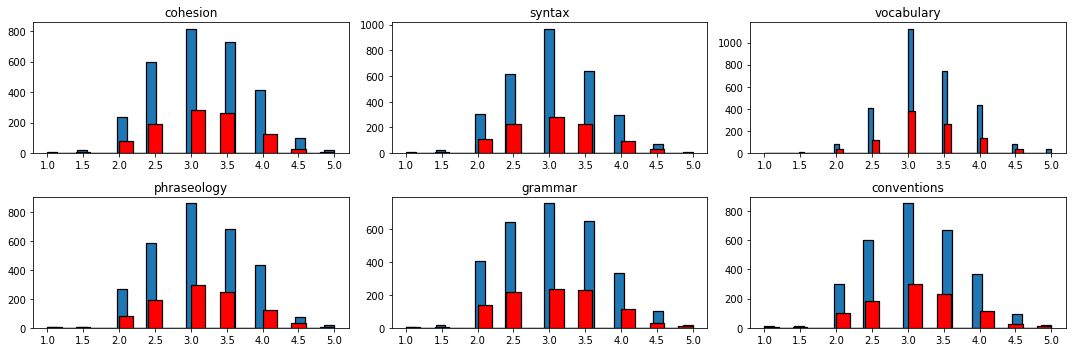

In [ ]:
## check the distribution of both training and validation distributions
## the way we split is enough to represent the dataset
fig, axes = plt.subplots(2, len(EEL_metrics)//2, figsize=(15,5))

for i, EEL_metric in enumerate(EEL_metrics):
    ax = axes.flat[i]
    sns.histplot(x=EEL_metric, data=x, linewidth=1.25, alpha=1, ax=ax, zorder=2)
    sns.histplot(x=EEL_metric, data=x_val, linewidth=1.25, alpha=1, ax=ax, zorder=2, color = 'red')
    ax.set_title(EEL_metric)
    ax.set(xlabel=None, ylabel=None)

#fig.suptitle('Output Variables')
plt.tight_layout()
plt.show()

In [ ]:
### defined a preprocessing function for the text,
### since we are evaluate all six different metrices, the punctuation and out of vocabulory are
### kind of important, so here only lower the case and replaced few things, like spaces.
def preprocessing(doc):
    doc = doc.lower()
    doc = re.sub('\[.*?\]', ' ', doc)
    #doc = re.sub('[%s]' % re.escape(string.punctuation), ' ', doc)
    #doc = re.sub('\w*\d\w*',' ', doc)
    doc = re.sub('\n','', doc)
    #doc = re.sub('[''""...]',' ', doc)
    doc = ' '.join(doc.split())

    return doc

In [ ]:
### append the cleaned text into the dataframe
x['cleaned_full_text'] = x['full_text'].apply(lambda x: preprocessing(x))
x_val['cleaned_full_text'] = x_val['full_text'].apply(lambda x: preprocessing(x))
test_ds['cleaned_full_text'] = test_ds['full_text'].apply(lambda x: preprocessing(x))


In [ ]:
### we can also check the polarity of the dataset using TextBlob
from textblob import TextBlob

textbb = []
for i in range(train_ds.shape[0]):
  textbb.append(TextBlob(train_ds['full_text'][i]).sentiment.polarity)


In [ ]:
len(textbb)

3911

In [ ]:
EEL_metrics = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']

In [ ]:
# check the tensorflow version
print(tf.__version__)

2.11.0


In [ ]:
#### need to install transformers everytime and also restart the runtime again.
#pip install transformers

In [ ]:
### same to install tensorflow_text
pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
### import neccessary packages again
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

tf.get_logger().setLevel('ERROR')

In [ ]:
# Load the  a BERT model to fine-tune
# here also added few other versions of BERT
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'

map_name_to_handle = {
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1'
}

map_model_to_preprocess = {

    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [ ]:
## we can start to build our own classifier model
## with few a output layer of 9 neurons for 9 classes.

## tried with an extra layer, took too long
##
from tensorflow.keras import activations

def build_classifier_model():

  #tb_input = tf.keras.layers.Input(shape=(1,), name = 'polarity')
  #y = tf.keras.layers.Dense(64, activation="relu")(tb_input)

  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')

  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)

  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']


  Dropout1 = tf.keras.layers.Dropout(0.3)(net)
  #dense1 = tf.keras.layers.Dense(64, activation=activations.relu, kernel_initializer="he_normal")(Dropout1)
  #combined1 = tf.concatenate([dense1, y ])
  #Dropout11 = tf.keras.layers.Dropout(0.3)(dense1)
  output1 = tf.keras.layers.Dense(9, activation = 'softmax', name=EEL_metrics[0])(Dropout1)


  Dropout2 = tf.keras.layers.Dropout(0.3)(net)
  #dense2 = tf.keras.layers.Dense(64, activation=activations.relu, kernel_initializer="he_normal")(Dropout2)
  #Dropout21 = tf.keras.layers.Dropout(0.3)(dense2)
  output2 = tf.keras.layers.Dense(9,activation = 'softmax', name=EEL_metrics[1])(Dropout2)

  Dropout3 = tf.keras.layers.Dropout(0.3)(net)
  #dense3 = tf.keras.layers.Dense(64, activation=activations.relu, kernel_initializer="he_normal")(Dropout3)
  #Dropout31 = tf.keras.layers.Dropout(0.3)(dense3)
  output3 = tf.keras.layers.Dense(9, activation = 'softmax',name=EEL_metrics[2])(Dropout3)

  Dropout4 = tf.keras.layers.Dropout(0.3)(net)
  #dense4 = tf.keras.layers.Dense(64, activation=activations.relu, kernel_initializer="he_normal")(Dropout4)
  #Dropout41 = tf.keras.layers.Dropout(0.3)(dense4)
  output4 = tf.keras.layers.Dense(9,activation = 'softmax', name=EEL_metrics[3])(Dropout4)

  Dropout5 = tf.keras.layers.Dropout(0.3)(net)
  #dense5 = tf.keras.layers.Dense(64, activation=activations.relu, kernel_initializer="he_normal")(Dropout5)
  #Dropout51 = tf.keras.layers.Dropout(0.3)(dense5)
  output5 = tf.keras.layers.Dense(9, activation = 'softmax',name=EEL_metrics[4])(Dropout5)

  Dropout6 = tf.keras.layers.Dropout(0.3)(net)
  #dense6 = tf.keras.layers.Dense(64, activation=activations.relu, kernel_initializer="he_normal")(Dropout6)
  #Dropout61 = tf.keras.layers.Dropout(0.3)(dense6)
  output6 = tf.keras.layers.Dense(9,activation = 'softmax', name=EEL_metrics[5])(Dropout6)



  return tf.keras.Model(text_input, outputs = [output1, output2, output3, output4, output5, output6])

In [ ]:
classifier_model = build_classifier_model()

In [ ]:
classifier_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                    

In [ ]:
print(classifier_model.non_trainable_weights)

[<tf.Variable 'Variable:0' shape=() dtype=bool, numpy=True>]


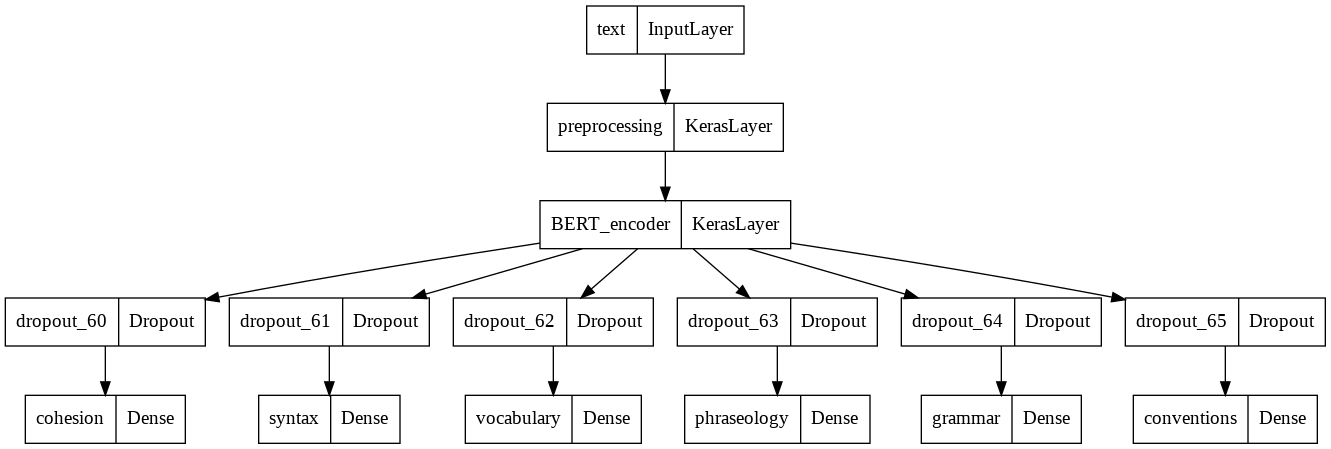

In [ ]:
from keras.utils import plot_model
plot_model(classifier_model)

In [ ]:
## Install addons to use check the phi coefficient.  if we use it
## The Matthews correlation coefficient (MCC) is used in machine learning as a measure of the quality of binary and multiclass classifications.
## It takes into account true and false positives and negatives and is generally regarded as a balanced measure which can be used even if the classes are of very different sizes.
## The correlation coefficient value of MCC is between -1 and +1.
## A coefficient of +1 represents a perfect prediction, 0 an average random prediction and -1 an inverse prediction. The statistic is also known as the phi coefficient.
# pip install tensorflow_addons

In [ ]:
### Since we are using classification approach, here use the sparsecategoricalcrossentropy
### as loss function and accuracy as metrics.
### optimizer using the adan with lr set to 0.0001

import tensorflow_addons as tfa

# Loss function:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
#metrics = tfa.metrics.MatthewsCorrelationCoefficient(num_classes=9)

# Loading the BERT model and training
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics = 'accuracy'
                         #loss = 'binary_crossentropy'
                         #metrics=[metrics]
                         )


In [ ]:
x_input = [i for i in x['cleaned_full_text']]
#y_input = [x[EEL_metrics[0]].values,x[EEL_metrics[1]].values,x[EEL_metrics[2]].values,
#           x[EEL_metrics[3]].values,x[EEL_metrics[4]].values,x[EEL_metrics[5]].values]
x_val_input = [i for i in x_val['cleaned_full_text']]
#y_val_input = [x_val[EEL_metrics[0]].values,x_val[EEL_metrics[1]].values,x_val[EEL_metrics[2]].values,
#              x_val[EEL_metrics[3]].values,x_val[EEL_metrics[4]].values,x_val[EEL_metrics[5]].values]
x_test_input = [i for i in test_ds['cleaned_full_text']]

In [ ]:
## encode the labels, same thing as below
#score = [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
#y_input = x[EEL_metrics].replace(
#    [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0], [ 1, 2, 3, 4, 5, 6, 7, 8,9])

#y_input = y_input.astype('int')
#y_input

In [ ]:
## get all the labels
y_all = [x[EEL_metrics[0]].values,x[EEL_metrics[1]].values,x[EEL_metrics[2]].values,
           x[EEL_metrics[3]].values,x[EEL_metrics[4]].values,x[EEL_metrics[5]].values]
y_all_input = [x_val[EEL_metrics[0]].values,x_val[EEL_metrics[1]].values,x_val[EEL_metrics[2]].values,
              x_val[EEL_metrics[3]].values,x_val[EEL_metrics[4]].values,x_val[EEL_metrics[5]].values]


In [ ]:
## label encoder our labels
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
label_enc = LabelEncoder().fit(y_all[0])
one_hot = OneHotEncoder()

In [ ]:
## have our label encoded.
y_input=[]
y_val_input=[]
for i in range(len(EEL_metrics)):
  y_input.append(label_enc.transform(y_all[i]))
  y_val_input.append(label_enc.transform(y_all_input[i]))

In [ ]:
## take a look at y_input, catergories from 0 to 8, corresponding to 9 classed( grades)
y_input

[array([0, 0, 0, ..., 8, 8, 8]),
 array([0, 0, 0, ..., 8, 8, 8]),
 array([0, 1, 1, ..., 8, 7, 8]),
 array([0, 0, 0, ..., 8, 8, 8]),
 array([0, 0, 0, ..., 7, 8, 8]),
 array([0, 0, 1, ..., 7, 8, 8])]

In [ ]:
## could've built vectors as well.
#y_1 = pd.get_dummies(label_enc.transform(y_input[0]))
#y_1

In [ ]:
## setup x_input as well.
## and also check the shape
x_input = np.stack(x_input, axis = 0)
#y_input = np.stack(y_input, axis = 1)
x_val_input = np.stack(x_val_input, axis = 0)
#y_val_input = np.stack(y_val_input, axis = 1)
x_test_input = np.stack(x_test_input, axis = 0)
x_input.shape, x_val_input.shape, #y_input.shape, y_val_input.shape

((2933,), (978,))

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x_input,
                               y_input,
                               validation_data=(x_val_input,y_val_input),
                               shuffle=True,
                               epochs=5)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5
92/92 [==============================] - 883s 9s/step - loss: 10.4868 - cohesion_loss: 1.7836 - syntax_loss: 1.7369 - vocabulary_loss: 1.6306 - phraseology_loss: 1.7535 - grammar_loss: 1.8288 - conventions_loss: 1.7534 - cohesion_accuracy: 0.2598 - syntax_accuracy: 0.2942 - vocabulary_accuracy: 0.3406 - phraseology_accuracy: 0.2683 - grammar_accuracy: 0.2492 - conventions_accuracy: 0.2820 - val_loss: 9.3877 - val_cohesion_loss: 1.5920 - val_syntax_loss: 1.5859 - val_vocabulary_loss: 1.4420 - val_phraseology_loss: 1.5589 - val_grammar_loss: 1.6282 - val_conventions_loss: 1.5807 - val_cohesion_accuracy: 0.2975 - val_syntax_accuracy: 0.3180 - val_vocabulary_accuracy: 0.4141 - val_phraseology_accuracy: 0.3344 - val_grammar_accuracy: 0.2812 - val_conventions_accuracy: 0.3528
Epoch 2/5
92/92 [==============================] - 860s 9s/step - loss: 9.3755 - cohesion_loss: 1.6252 - syntax_loss:

In [ ]:
history_loss = [x + '_loss' for x in EEL_metrics]
history_accuracy = [x + '_accuracy' for x in EEL_metrics]
history_val_loss = ['val_' + x + '_loss' for x in EEL_metrics]
history_val_accuracy = ['val_' + x + '_accuracy' for x in EEL_metrics]

In [ ]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.grid(True)


def plot_full_loss(history):
    plt.rcParams["figure.figsize"] = (10,6)
    for i in range(len(EEL_metrics)):
      plt.plot(history.history[history_loss[i]], label = history_loss[i])
      plt.plot(history.history[history_val_loss[i]], label = history_val_loss[i])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

def plot_full_accuracy(history):
    plt.rcParams["figure.figsize"] = (10,8)
    for i in range(len(EEL_metrics)):
      plt.plot(history.history[history_accuracy[i]], label = history_accuracy[i])
      plt.plot(history.history[history_val_accuracy[i]], label = history_val_accuracy[i])
    plt.xlabel('Epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.grid(True)

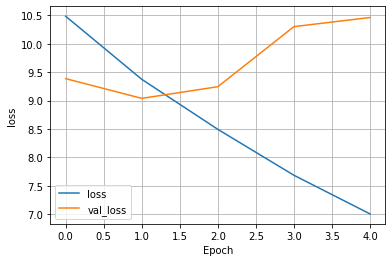

In [ ]:
plot_loss(history)

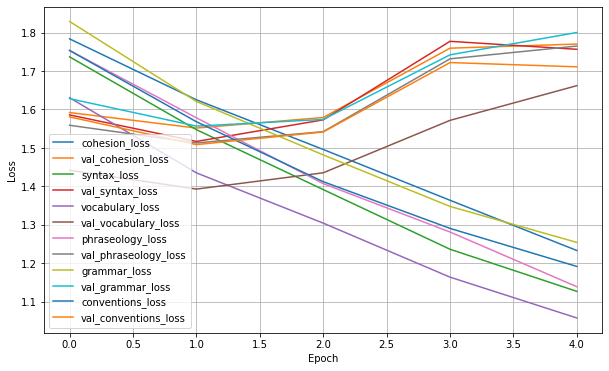

In [ ]:
plot_full_loss(history)

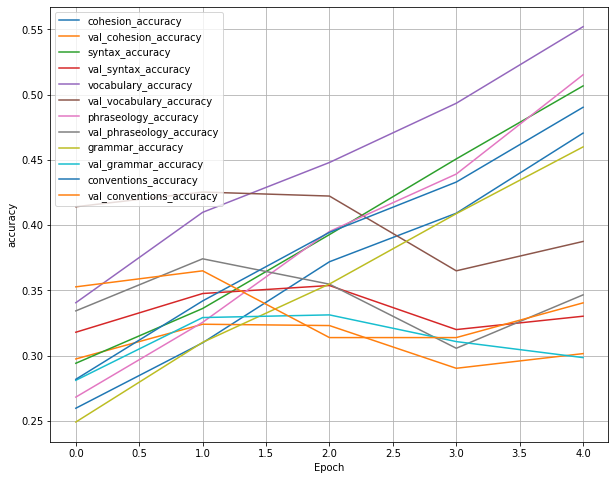

In [ ]:
plot_full_accuracy(history)

In [ ]:
predict = classifier_model.predict(x_test_input)
pd.DataFrame(predict)

1/1 [==============================] - 1s 973ms/step


[array([[0.00087991, 0.00086769, 0.02166773, 0.1419627 , 0.6463059 ,
         0.16921982, 0.01596915, 0.00198638, 0.00114064],
        [0.00451025, 0.00407822, 0.1484875 , 0.3554126 , 0.40050897,
         0.07626557, 0.00463075, 0.00256947, 0.00353668],
        [0.00470275, 0.00107211, 0.00363564, 0.01157817, 0.04802183,
         0.17679003, 0.6411747 , 0.08113395, 0.03189096]], dtype=float32),
 array([[0.00087855, 0.0017402 , 0.10322863, 0.3097255 , 0.47679612,
         0.08178911, 0.02064646, 0.003496  , 0.00169952],
        [0.00336123, 0.00485737, 0.30309433, 0.56275   , 0.09266167,
         0.02729282, 0.00300633, 0.00135522, 0.00162101],
        [0.00492329, 0.00529145, 0.0019548 , 0.00366753, 0.08827869,
         0.3556574 , 0.47346437, 0.05476649, 0.01199598]], dtype=float32),
 array([[3.43195628e-04, 9.95303271e-04, 6.75806496e-03, 6.96168020e-02,
         4.83731031e-01, 3.91987890e-01, 4.10722122e-02, 4.66233538e-03,
         8.33149767e-04],
        [8.01655347e-04, 1.94653

In [ ]:
sample_sub

,text_id,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0000C359D63E,3.0,3.0,3.0,3.0,3.0,3.0
1,000BAD50D026,3.0,3.0,3.0,3.0,3.0,3.0
2,00367BB2546B,3.0,3.0,3.0,3.0,3.0,3.0


In [ ]:
predict[0][2]

array([0.00470275, 0.00107211, 0.00363564, 0.01157817, 0.04802183,
       0.17679003, 0.6411747 , 0.08113395, 0.03189096], dtype=float32)

In [ ]:
for i in range(len(EEL_metrics)):
  for j in range(3):
    sample_sub[EEL_metrics[i]][j] = np.argmax(predict[i][j])

<ipython-input-159-0a3e43bd1d8b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_sub[EEL_metrics[i]][j] = np.argmax(predict[i][j])


In [ ]:
sample_sub

,text_id,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0000C359D63E,4,4,4,4,4,4
1,000BAD50D026,4,3,4,4,3,3
2,00367BB2546B,6,6,6,6,6,6


In [ ]:
# with the smallBert The input is truncated to 128 tokens (The number of tokens can be customized)
sample_sub[EEL_metrics].replace([ 0, 1, 2, 3, 4, 5, 6, 7, 8] , [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0])


,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,3.0,3.0,3.0,3.0,3.0,3.0
1,3.0,2.5,3.0,3.0,2.5,2.5
2,4.0,4.0,4.0,4.0,4.0,4.0


In [ ]:
### Take a look at test_ds 1 and 2, looks 2 is better.

In [ ]:
test_ds['full_text'][2]

'Thomas Jefferson once states that "it is wonderful how much we can get done when we are always doing something,I agree to this statement. Some people say that it is always better to always be doing something than to be inactive and so nothing at all to chase after on your dreams. always doing something lets you feel a sense of accomplishment,it makes you want to strive to do even more than what you did,you can also learn something along the way.\n\nThe first reason that always doing is better than doing nothing is that it gives you a sense of you accomplishing something. when you finish a task you feel successful with yourself in saying that you pursued something and kept going. for example,when you graduate from school and move on to collage,you feel successful you also know that you worked as hard as you can to complete your schooling and onto collage or even to the real world to work.\n\nSecondly,accomplishing your goals makes you want to strive to do more. when you complete someth

In [ ]:
test_ds['full_text'][1]

"Do you think students would benefit from being able attend classes from home?\n\nYes! its benefit for student who attend classes from home. Because some student want to attend classes from home because they thinks it's very important for them . And they think they can learned fast, and understand than they student who attend classes from school. For example my friend told me that she's attand classes from home it's good for her, because they is some subject she didn't understand when she attend classes from school but when she attend the home classes she good for that subject. she like science she think science its important for her but she didn't understand anything any science but she understand science because she attend classes from home. And some parent doesn't want they are children to attend classes from school, because many christian doesn't want they are children to attend to classes from school because they doesn't believe science and they want they are children to be disres

In [ ]:
x_input[0]

'some student offer distance learning as an option for student to attend classes from homr by wat of online pr video conferencing. i think student would benefit form being able to attend classesfrom home. you are authorized take the electronic version of this you will taking this promptsome student offer distance learning as an option for student to attend classes from homr by wat of online pr video conferencing. some student offer distance learning as an option for student to attend classes from homr by wat of online pr video conferencing. some student offer distance learning as an option.online pr video conferencing. the right view the prompt and teh checklist for writers vvsome student offer distance learning as an option for student to attend classes from homr by wat of online pr video conferencing. some student offer distance learning as an option for student to attend classes from homr by wat of online pr video conferencing. some student offer distance learning as an option for s

In [ ]:
x_test_Train = x_input[:1]

In [ ]:
test = classifier_model.predict(x_test_Train)

1/1 [==============================] - 0s 129ms/step


In [ ]:
test

[array([[0.3891567 , 0.2929403 , 0.01355844, 0.00943811, 0.00275476,
         0.00555132, 0.00622435, 0.07520558, 0.20517045]], dtype=float32),
 array([[0.21506695, 0.7433345 , 0.00691156, 0.00484853, 0.00302283,
         0.0033967 , 0.00308   , 0.00312731, 0.01721169]], dtype=float32),
 array([[0.5071662 , 0.31417722, 0.11686143, 0.00925538, 0.01124137,
         0.00187596, 0.00315297, 0.01741539, 0.01885412]], dtype=float32),
 array([[0.75463086, 0.14972995, 0.01016958, 0.00401805, 0.01771468,
         0.00970666, 0.01492383, 0.00313201, 0.03597447]], dtype=float32),
 array([[0.21724215, 0.30155367, 0.05351608, 0.00988913, 0.01146523,
         0.01376334, 0.01315404, 0.29238832, 0.08702803]], dtype=float32),
 array([[0.56440884, 0.30501172, 0.02673489, 0.00463481, 0.01437356,
         0.01256418, 0.02366198, 0.0235457 , 0.02506432]], dtype=float32)]

In [ ]:
test_score =[]
for i in range(len(EEL_metrics)):
    test_score.append(np.argmax(test[i]))

In [ ]:
### Looks okay
pd.DataFrame(test_score).replace([ 0, 1, 2, 3, 4, 5, 6, 7, 8] , [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0])

,0
0,1.0
1,1.5
2,1.0
3,1.0
4,1.5
5,1.0
